# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Построить модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измерить *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

In [1]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('/datasets/Churn.csv')
print(data.dtypes)
data.head()


RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


***
- Есть пропущенные значения 
- Типы данных в стролбцах Surname, Geography и Geder не подходящие 
***

In [2]:
data = data.drop(['Surname', 'CustomerId', 'RowNumber'], axis=1) 
print(data.isnull().sum())
tenure_avg = data['Tenure'].median()
data['Tenure'] = data['Tenure'].fillna(value = tenure_avg)


data_new = pd.get_dummies(data, drop_first=True)
data_new

CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,1,0,1


- Удаляем столбец Surname
- Заменяем все Nun в столбце Tenure на медиану 
- Так же все оставшиеся строковые значения заменим на числовые


In [3]:
train, valid, test = np.split(data_new.sample(frac=1, random_state=42),
                                 [int(.6*len(data_new)), int(.8*len(data_new))])

# переменные для признаков и целевого признака
features_train = train.drop(['Exited'], axis=1)
target_train = train['Exited']

features_valid = valid.drop(['Exited'], axis=1)
target_valid = valid['Exited'] 

features_test = test.drop(['Exited'], axis=1)
target_test = test['Exited']
print(train.shape)
print(valid.shape)
print(test.shape)

(6000, 12)
(2000, 12)
(2000, 12)


***Создаем 3 выборки: Обучающию, валидную и тестовую*** 

# 2. Исследование задачи

6252    0
4684    0
1731    0
4742    0
4521    0
       ..
7895    0
9590    0
7288    0
278     0
3252    0
Name: Exited, Length: 6000, dtype: int64


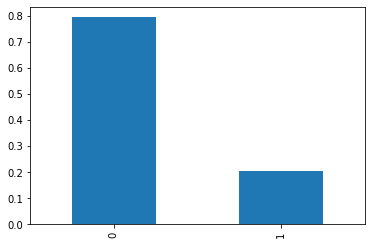

In [4]:
# чтобы работала функция value_counts(), преобразовываем результат к pd.Series 
class_frequency = target_train.value_counts(normalize=(0, 1))
print(target_train)
class_frequency.plot(kind='bar') 

***Количество положительный и отрицательных исходов очень разняться это негативно влияет на обучение модели*** 

# 3. Борьба с дисбалансом

In [5]:
model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print(f1_score(target_valid, predicted_valid))

model1 = LogisticRegression(random_state=12345, class_weight='balanced') # балансировка классов 
model1.fit(features_train, target_train)
predicted_valid_balanced = model1.predict(features_valid)
print(f1_score(target_valid, predicted_valid_balanced))

0.0049382716049382715


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.4716157205240175


***При болонсировке классов F1 критерий повышается ( Значит это, то чего не хватате для кореектной работы)***

In [6]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.2) # уменьшение выборки в 10 раз 

downsample_model = LogisticRegression(random_state=12345, class_weight='balanced')
downsample_model.fit(features_downsampled, target_downsampled)
downsample_predicted_valid = downsample_model.predict(features_valid)

print("F1:", f1_score(target_valid, downsample_predicted_valid))

F1: 0.46616541353383467


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [7]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4) # увелечение выборки в 4 раз 

upsample_model = LogisticRegression(random_state=12345, class_weight='balanced')
upsample_model.fit(features_upsampled, target_upsampled)
upsample_predicted_valid = upsample_model.predict(features_valid)
print("F1:", f1_score(target_valid, upsample_predicted_valid))

F1: 0.45611156685808035


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


- Увеличив и уменьшив выборку можно увидеть что F1 критерий вырос. Особенно при умешение выборки. 
- Думаю дальше можно смело использовать features_downsampled, target_downsampled что бы модель получилась более коректная

0    0.6
1    0.4
dtype: float64


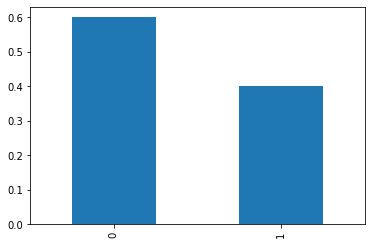

In [8]:
downsample_predicted_valid = pd.Series(downsample_model.predict(features_valid))
class_frequency = downsample_predicted_valid.value_counts(normalize=(0, 1))
print(class_frequency)
class_frequency.plot(kind='bar') 


0    0.589
1    0.411
dtype: float64


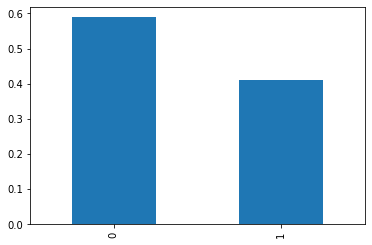

In [9]:
upsample_predicted_valid = pd.Series(upsample_model.predict(features_valid))
class_frequency = upsample_predicted_valid.value_counts(normalize=(0, 1))
print(class_frequency)
class_frequency.plot(kind='bar') 

In [10]:
features_train = features_upsampled
target_train  = target_upsampled

***Создаем новые данные. Так-как размер выборки был уменьшен***

# 4. Тестирование модели

In [11]:
%%time

best_result = 0
best_model = None
for depth in range(1, 20, 1):
        model = RandomForestClassifier(n_estimators=151, max_depth=depth, random_state=12345, class_weight='balanced')
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        r2 = f1_score(predicted_valid, target_valid)
        if r2 > best_result:
            best_result = r2
            best_model = model
print(r2,'\n' ,best_model)

0.6293333333333334 
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=151, n_jobs=None, oob_score=False,
                       random_state=12345, verbose=0, warm_start=False)
CPU times: user 18.8 s, sys: 125 ms, total: 18.9 s
Wall time: 19 s


***В ячейке выше я нашел максимальную глубину деревьев***

***Максимальная глубина дерева 12***

In [12]:
%%time

model = RandomForestClassifier(n_estimators=151, max_depth=12 , random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)


CPU times: user 1.12 s, sys: 3.8 ms, total: 1.13 s
Wall time: 1.13 s


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=151, n_jobs=None, oob_score=False,
                       random_state=12345, verbose=0, warm_start=False)

***Лучшая модель. Дальше я тестирую все на ней.***

In [13]:
predictions_train = model.predict(features_train) # предсказания на обучающей 
predictions_valid = model.predict(features_valid) # предсказания на валидной
predictions_test = model.predict(features_test)

print("Наилучшая модель")
print("MAE на обучающей выборке: ", mean_absolute_error(target_train, predictions_train)) 
print("MAE на валидационной выборке: ", mean_absolute_error(target_valid, predictions_valid))
print("MAE на тестовой выборке: ", mean_absolute_error(target_test, predictions_test))

Наилучшая модель
MAE на обучающей выборке:  0.029514963880288958
MAE на валидационной выборке:  0.1525
MAE на тестовой выборке:  0.177


In [14]:
predicted_valid = model.predict(features_valid)
predicted_test = model.predict(features_test)
predicted_train = model.predict(features_train)

print("F1:", f1_score(target_train, predicted_train)) # F1-score
print("F1:", f1_score(target_valid, predicted_valid)) # F1-score
print("F1:", f1_score(target_test, predicted_test)) # F1-score

F1: 0.9710935920760057
F1: 0.6381969157769869
F1: 0.5703883495145631


***F1 на много лучше 0.59***

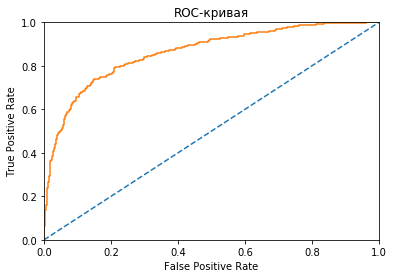

0.8623079207594073


In [15]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) # значения FPR, значения TPR и рассмотренные пороги
plt.figure()

# < постройте график >

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 


auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # случайная 0.5 (Лучшая 1)
print(auc_roc)

***По AUC-ROC можно судить что модель работает ***

# 5. Вывод


Самая лучшая модель это Случайный лес. Хоть и выпоняется долго, но имеет лучшую точность.
- AUC-ROC имеет точность 0.86 Это довольно хороший результат и он сильно отличается он случайного 0.5 (это видно на графике)
- F1: 0.64 на валидной и 0.57 на тестовой 
- Лучшая модель это лес решений с параметрами (n_estimators=151, max_depth=12)
